# Path setup & import packages

In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2
import sys
import os
root_path = '../../' # path to project root
sys.path.append('{}/code'.format(root_path))
sys.path.append('{}/code/core'.format(root_path))
sys.path.append('{}/code/datasets/'.format(root_path))
sys.path.insert(0,'{}/code/ptranking'.format(root_path))

from core.ranking_utils import *
from core.mallows import *
from core.ws_ranking import *
from core.ws_real_workflow import * 
from datasets.imdb_tmdb_dataset import * 
from datasets.basic_clmn_dataset import * 
from core.labelling.feature_lf import *
from ptranking_wrapper import PtrankingWrapper
import datasets_factory 
import numpy as np 
import yaml
import matplotlib.pyplot as plt
import pickle

# Read config & basic setup

In [2]:
config_file_path = '{}/configs/board-games_ranking_experiment.yaml'.format(root_path)

with open(config_file_path,'r') as conf_file:
    conf = yaml.full_load(conf_file)
    conf['project_root'] = root_path 

data_conf = conf['data_conf']
weak_sup_conf = conf['weak_sup_conf'] # For partial ranking experiments, we should give
l2r_training_conf = conf['l2r_training_conf']
data_conf['project_root'] = root_path

# Dataset sampling

In [3]:
dataset= datasets_factory.create_dataset(data_conf)
dataset.create_samples()

Generate samples...


# Label model learning & inference

In [4]:
if l2r_training_conf['use_weak_labels']:
    Y_tilde, thetas = get_weak_labels(dataset, weak_sup_conf, root_path=root_path)
    r_utils = RankingUtils(data_conf['dimension'])
    kt = r_utils.mean_kt_distance(Y_tilde,dataset.Y)
    print('kt distance: ', kt)
    dataset.set_Y_tilde(Y_tilde)
else:
    kt = None

# Train and evaluation - mainly with PtrankingWrapper

In [5]:
ptwrapper = PtrankingWrapper(data_conf=data_conf, weak_sup_conf=weak_sup_conf,
                             l2r_training_conf=l2r_training_conf, result_path=conf['results_path'],
                             wl_kt_distance = kt)
X_train, X_test, Y_train, Y_test = dataset.get_train_test_torch(use_weak_labels=l2r_training_conf['use_weak_labels'])
ptwrapper.set_data(X_train=X_train, X_test=X_test,
                  Y_train=Y_train, Y_test=Y_test)
model = ptwrapper.get_model()
result = ptwrapper.train_model(model, verbose=1)

use_weak_labels:False, we will use true labels
Training data shape, X_train.shape torch.Size([500, 5, 14]) Y_train.shape torch.Size([500, 5])
data_dict {'data_id': 'board-games', 'dir_data': 'data/board-games/processed/default', 'min_docs': 10, 'min_rele': 1, 'scale_data': False, 'scaler_id': None, 'scaler_level': None, 'train_presort': True, 'validation_presort': True, 'test_presort': True, 'train_batch_size': 64, 'validation_batch_size': 1, 'test_batch_size': 64, 'unknown_as_zero': False, 'binary_rele': False, 'num_features': 14, 'has_comment': False, 'label_type': <LABEL_TYPE.Permutation: 2>, 'max_rele_level': None, 'fold_num': 1}
data_dict {'data_id': 'board-games', 'dir_data': 'data/board-games/processed/default', 'min_docs': 10, 'min_rele': 1, 'scale_data': False, 'scaler_id': None, 'scaler_level': None, 'train_presort': True, 'validation_presort': True, 'test_presort': True, 'train_batch_size': 64, 'validation_batch_size': 1, 'test_batch_size': 64, 'unknown_as_zero': False, 'bin

# Training log visualization

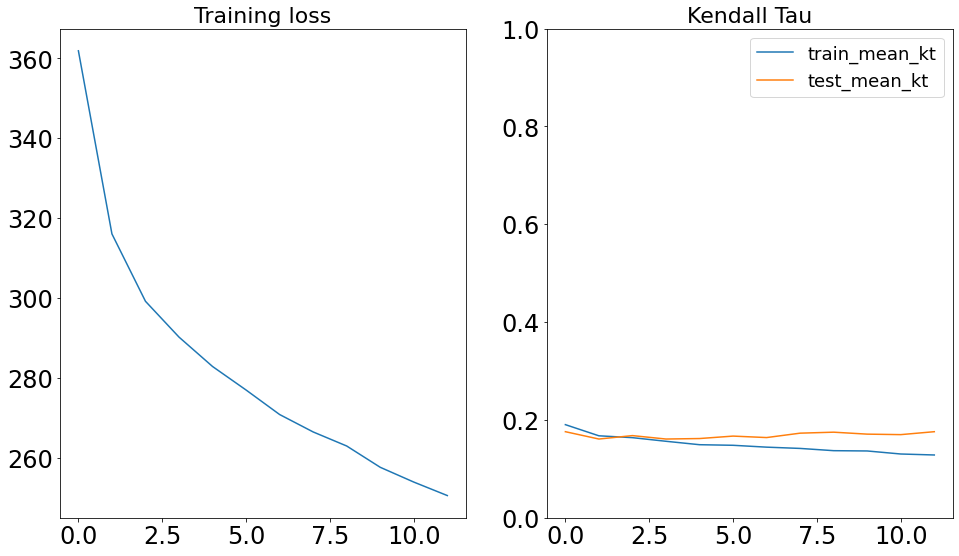

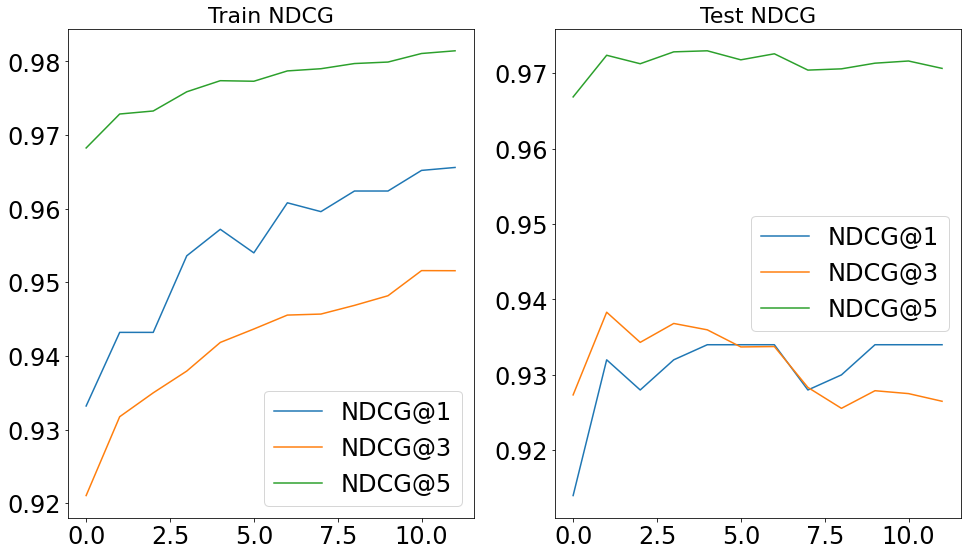

In [6]:
plt.rcParams['font.size'] = '24'
losses = result['loss']
train_tau = result['train_tau']
test_tau = result['test_tau']
train_ndcg1 = result['train_ndcg1']
train_ndcg3 = result['train_ndcg3']
train_ndcg5 = result['train_ndcg5']
test_ndcg1 = result['test_ndcg1']
test_ndcg3 = result['test_ndcg3']
test_ndcg5 = result['test_ndcg5']


fig, axes = plt.subplots(ncols=2, figsize=(16,9))
axes[0].plot(losses)
axes[0].set_title(f'Training loss', fontsize=22)
axes[1].plot(train_tau, label='train_mean_kt')
axes[1].plot(test_tau, label='test_mean_kt')
axes[1].set_ylim(0,1)
axes[1].legend(fontsize=18)
axes[1].set_title(f'Kendall Tau', fontsize=22)
plt.show()

fig, axes = plt.subplots(ncols=2, figsize=(16,9))
axes[0].plot(train_ndcg1, label='NDCG@1')
axes[0].plot(train_ndcg3, label='NDCG@3')
axes[0].plot(train_ndcg5, label='NDCG@5')
axes[0].legend()
axes[0].set_title(f'Train NDCG', fontsize=22)
axes[1].plot(test_ndcg1, label='NDCG@1')
axes[1].plot(test_ndcg3, label='NDCG@3')
axes[1].plot(test_ndcg5, label='NDCG@5')
axes[1].set_title(f'Test NDCG', fontsize=22)
axes[1].legend()
plt.show()